In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
# !pip install ensemble-boxes

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from matplotlib import pyplot as plt
from utils import *

In [4]:
from ensemble_boxes import *
def run_wbf(boxes, scores, image_size=1023, iou_thr=0.5, skip_box_thr=0.7, weights=None):
    #boxes = [prediction[image_index]['boxes'].data.cpu().numpy()/(image_size-1) for prediction in predictions]
    #scores = [prediction[image_index]['scores'].data.cpu().numpy() for prediction in predictions]
    labels = [np.zeros(score.shape[0]) for score in scores]
    boxes = [box/(image_size) for box in boxes]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=weights, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    #boxes, scores, labels = nms(boxes, scores, labels, weights=[1,1,1,1,1], iou_thr=0.5)
    boxes = boxes*(image_size)
    return boxes, scores, labels

In [5]:
def TTAImage(image, index):
    image1 = image.copy()
    if index==0: 
        rotated_image = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
        return rotated_image
    elif index==1:
        rotated_image2 = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
        rotated_image2 = cv2.rotate(rotated_image2, cv2.ROTATE_90_CLOCKWISE)
        return rotated_image2
    elif index==2:
        rotated_image3 = cv2.rotate(image1, cv2.ROTATE_90_CLOCKWISE)
        rotated_image3 = cv2.rotate(rotated_image3, cv2.ROTATE_90_CLOCKWISE)
        rotated_image3 = cv2.rotate(rotated_image3, cv2.ROTATE_90_CLOCKWISE)
        return rotated_image3
    elif index == 3:
        return image1

In [6]:
def rotBoxes90(boxes, im_w, im_h):
    ret_boxes =[]
    for box in boxes:
        x1, y1, x2, y2 = box
        x1, y1, x2, y2 = x1-im_w//2, im_h//2 - y1, x2-im_w//2, im_h//2 - y2
        x1, y1, x2, y2 = y1, -x1, y2, -x2
        x1, y1, x2, y2 = int(x1+im_w//2), int(im_h//2 - y1), int(x2+im_w//2), int(im_h//2 - y2)
        x1a, y1a, x2a, y2a = min(x1, x2), min(y1, y2), max(x1, x2), max(y1, y2)
        ret_boxes.append([x1a, y1a, x2a, y2a])
    return np.array(ret_boxes)

In [7]:
from detectron2.config import get_cfg
cfg = get_cfg()

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_cascade_rcnn_ResNeSt_101_FPN_syncbn_range-scale_1x.yaml"))
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # 


cfg.MODEL.WEIGHTS = os.path.join('./output_6/', "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2 # set the testing threshold for this model
# cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.45
cfg.DATASETS.TEST = ("m5_val", )
predictor1 = DefaultPredictor(cfg)

In [8]:
import pandas as pd
df_val = pd.read_csv("../data/val_aug.csv")

In [9]:
iou_thresholds = []
for x in [0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    iou_thresholds.append(x)

In [10]:
def calculate_image_precision(gts, preds, thresholds = iou_thresholds, form = 'pascal_voc'):
    n_threshold = 6
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1


    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [11]:
def predictImg(img):
    outputs = predictor1(img)
    out = outputs["instances"].to("cpu")
    scores = out.get_fields()['scores'].numpy()
    boxes = out.get_fields()['pred_boxes'].tensor.numpy().astype(int)
    labels= out.get_fields()['scores'].numpy()
    return boxes,scores

In [12]:
def swapCord(bbox,index=0):
    boxes[:,index] = 1024-boxes[:,index] 
    boxes[:,index+2] = 1024-boxes[:,index+2] 
    a = boxes[:,index].copy()
    boxes[:,index] = boxes[:,index+2].copy()
    boxes[:,index+2] = a
    return boxes

In [14]:
import cv2
import glob
from tqdm import tqdm
results = []
%matplotlib inline

final_scores = []
ttqdm = tqdm(list(set(df_val['image_id'])))
for image_id in ttqdm:
    ebbox = []
    escore = []
    gt = df_val[df_val.image_id == image_id].values[:,3:]
    im = cv2.imread('../data/val2/{}.jpg'.format(image_id))
    im_w, im_h = im.shape[:2]
    boxes,scores = predictImg(im) 
    ebbox.append(boxes)
    escore.append(scores)
    
#     img_flip = np.flip(im,0)
#     boxes,scores = predictImg(img_flip) 
#     boxes = swapCord(boxes,1)
#     ebbox.append(boxes)
#     escore.append(scores)
    
    img_flip = np.flip(im,1)
    boxes,scores = predictImg(img_flip) 
    boxes = swapCord(boxes,0)
    ebbox.append(boxes)
    escore.append(scores)
    
#     img_flip = np.flip(np.flip(im,1),0)
#     boxes,scores = predictImg(img_flip) 
#     boxes = swapCord(boxes,0)
#     boxes = swapCord(boxes,1)
#     ebbox.append(boxes)
#     escore.append(scores)
    boxes, scores, labels = run_wbf(ebbox, escore, image_size=1023, iou_thr=0.55, skip_box_thr=0.45, weights=[0.7,0.3])
    boxes = boxes[scores >= 0.1].astype(np.int32)
    scores = scores[scores >=float(0.1)]
    results.append({"image_id":image_id,"bboxs":ebbox,"scores":escore,"gt":gt})
    gt_boxes = gt.copy()
    gt_boxes[:,2] = gt_boxes[:,0] + gt_boxes[:,2]  
    gt_boxes[:,3] = gt_boxes[:,1] + gt_boxes[:,3]  
    image_precision = calculate_image_precision(gt_boxes, boxes)
    final_scores.append(image_precision)
    ttqdm.set_description("image_precision: {}, final_scores: {}".format(image_precision,np.mean(final_scores)))
# #     print(np.mean(final_scores))
#     if image_precision<0.6:
#         image = im.copy()
#         size = 300
#         font = cv2.FONT_HERSHEY_SIMPLEX 

#         # fontScale 
#         fontScale = 1

#         # Blue color in BGR 
#         color = (255, 0, 0) 

#         # Line thickness of 2 px 
#         thickness = 2
#         for b,s in zip(boxes,scores):
#             image = cv2.rectangle(image, (b[0],b[1]), (b[2],b[3]), (255,0,0), 2) 
#             image = cv2.putText(image, '{:.2}'.format(s), (b[0],b[1]), font,  
#                            fontScale, color, thickness, cv2.LINE_AA)
#         for b in gt:
#             image = cv2.rectangle(image, (b[0],b[1]), (b[0]+b[2],b[1]+b[3]), (0,255,0), 2) 

#         plt.figure(figsize=[20,10])
#         plt.subplot(121)
#         plt.imshow(im[:,:,::-1])
#         plt.title(scores.mean())
#         plt.subplot(122)
#         plt.imshow(image[:,:,::-1])
#         plt.title(image_precision)
#         plt.show()
#     break

  0%|          | 0/675 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
image_precision: 0.7687331187331187, final_scores: 0.7687331187331187:   0%|          | 1/675 [00:01<17:03,  1.52s/it]/opt/conda/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:73: UserWarning: X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('X2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
/opt/conda/lib/python3.7/site-packages/ensemble_boxes/ensemble_boxes_wbf.py:85: UserWarning: Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.
  warnings.warn('Y2 > 1 in box. Set it to 1. Check that you normalize boxes in [0, 1] range.')
image_precision: 0.39336589336589334, final_scores:

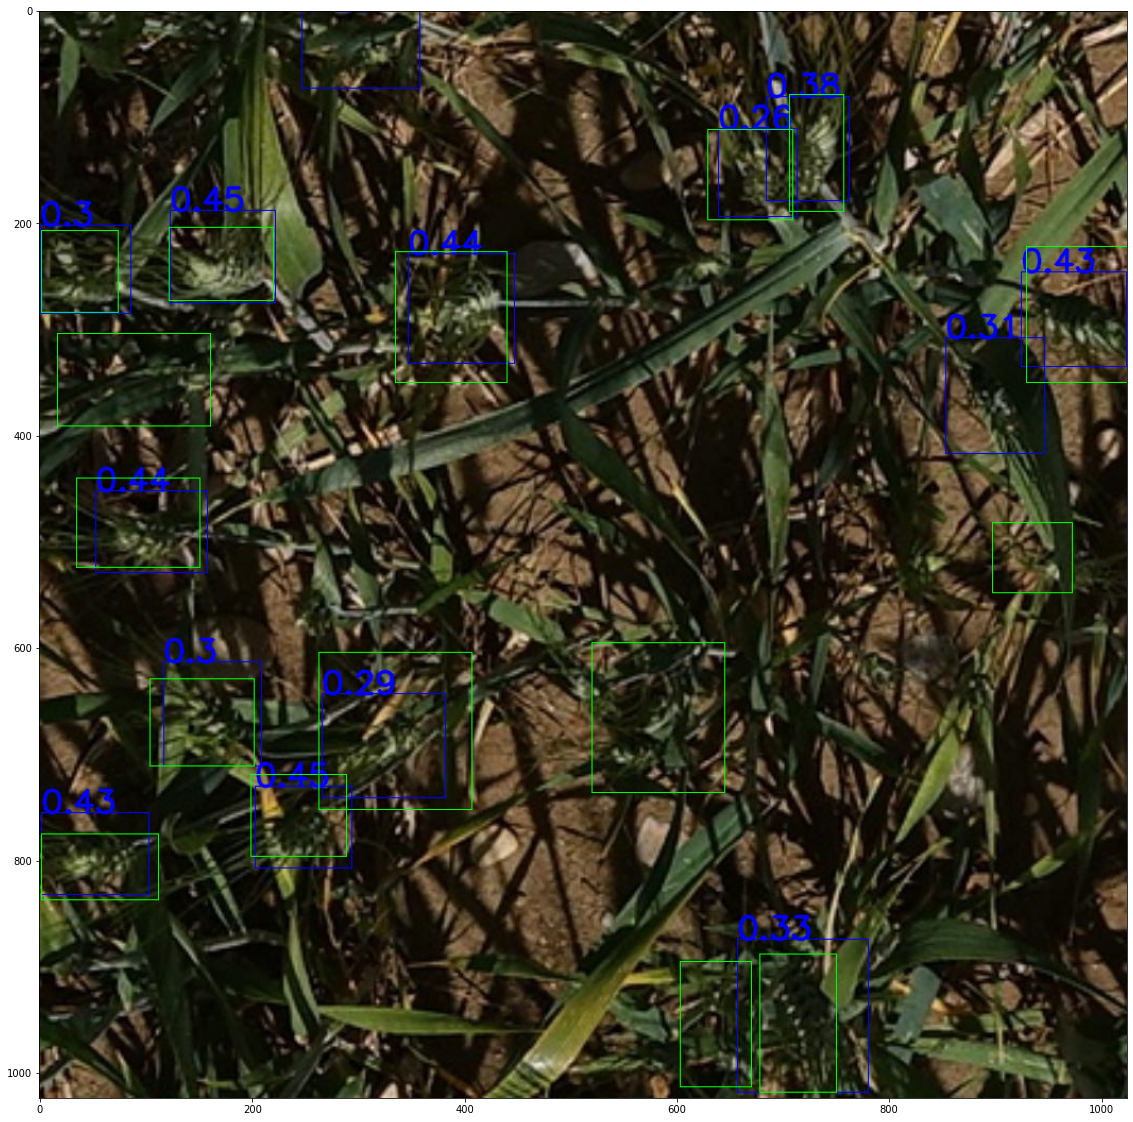

In [15]:
from matplotlib import pyplot as plt
image = im.copy()
size = 300
font = cv2.FONT_HERSHEY_SIMPLEX 
    
# fontScale 
fontScale = 1
   
# Blue color in BGR 
color = (255, 0, 0) 
  
# Line thickness of 2 px 
thickness = 2
for b,s in zip(boxes,scores):
    image = cv2.rectangle(image, (b[0],b[1]), (b[2],b[3]), (255,0,0), 1) 
    image = cv2.putText(image, '{:.2}'.format(s), (b[0],b[1]), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
for b in gt_boxes:
    image = cv2.rectangle(image, (b[0],b[1]), (b[2],b[3]), (0,255,0), 1) 
    
plt.figure(figsize=[20,20])
plt.imshow(image[:,:,::-1])
plt.show()

In [17]:
final_scores = []
for row in tqdm(range(len(results))):
    gt_boxes = results[row]['gt'].copy()
    gt_boxes[:,2] = gt_boxes[:,0] + gt_boxes[:,2]  
    gt_boxes[:,3] = gt_boxes[:,1] + gt_boxes[:,3]  
    ebbox = results[row]['bboxs'] 
    escore = results[row]['scores']
    boxes, scores, labels = run_wbf(ebbox, escore, image_size=1023, iou_thr=0.6, skip_box_thr=0.55)
#     boxes = boxes[scores >= 0.1].astype(np.int32)
    image_precision = calculate_image_precision(gt_boxes, boxes)
    final_scores.append(image_precision)
np.mean(final_scores)

100%|██████████| 675/675 [00:35<00:00, 18.92it/s]


0.7087144634231825